In [234]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import os
import math
import numpy as np
import torch as t
import torch.utils.data as tdata
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from einops import rearrange
from dots.training import *
from dots.trainhooks import *
from dots.datasets import get_dataset
from dots.models import BasicCNN
from dots.dots import *
from dots.utils import *
from dots.plotting import *
from dots.experiment import get_train_state, get_config_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
failed = load_model("jolly-sweep-29")
succeeded = load_model("hardy-sweep-27")
ds = get_dataset("mnist")
test_ds = dataset_from_end(ds, 1000)

In [89]:
small_rand = random_batch(4, (1, 28, 28))
small_data = tensor_of_dataset(ds, [0, 1, 2, 3])

same_class_data = class_examples(test_ds, 0, 4)

close_rand = perturbed_copies(random_batch(1, (1, 28, 28))[0], 4)
close_data = perturbed_copies(tensor_of_dataset(ds, [0])[0], 4)

id_data = tensor_of_dataset(ds, [0, 0, 0, 0])

vclose_data = tensor_of_dataset(ds, [0, 0, 0, 0]).clone()
vclose_data[1, 0, 0, 0] += 0.01
vclose_data[2, 0, 0, 1] += 0.01
vclose_data[3, 0, 1, 0] += 0.01

for a in [small_rand, small_data, same_class_data, close_rand, close_data]:
    print(a.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4, 1, 28, 28])
torch.Size([4, 1, 28, 28])
torch.Size([4, 1, 28, 28])
torch.Size([4, 1, 28, 28])


In [71]:
same_class_data.shape

torch.Size([4, 1, 28, 28])

In [72]:
def plot_imgs(ds):
    n = len(ds)
    fig, axs = plt.subplots(1, n, figsize=(12, 7))
    for i in range(n):
        axs[i].imshow(ds[i, 0].cpu().numpy().squeeze(), cmap="gray")
        axs[i].axis("off")

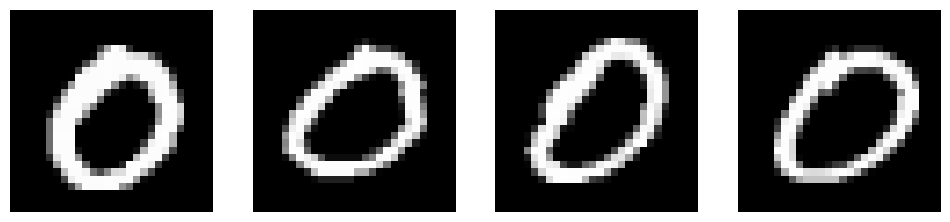

In [73]:
plot_imgs(same_class_data)

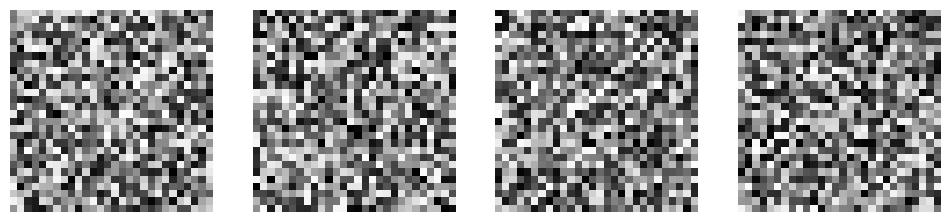

In [74]:
plot_imgs(small_rand)

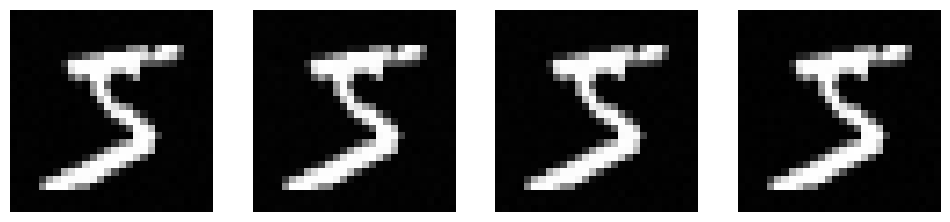

In [75]:
plot_imgs(close_data)

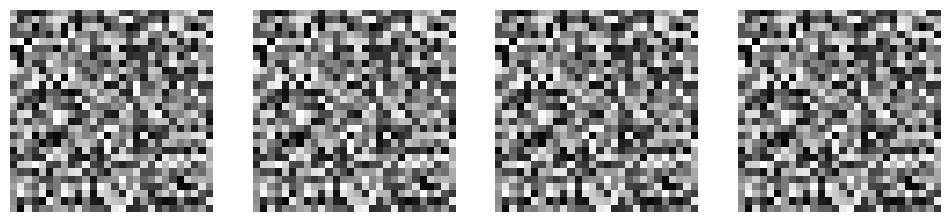

In [76]:
plot_imgs(close_rand)

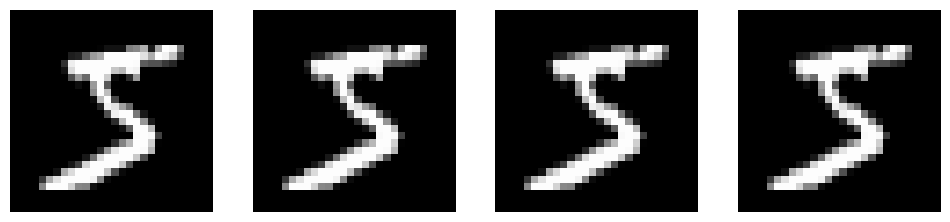

In [81]:
plot_imgs(id_data)

In [77]:
print(f"Accuracy of failed model: {accuracy(failed, test_ds)}")
print(f"Accuracy of succeeded model: {accuracy(succeeded, test_ds)}")

Accuracy of failed model: 0.09399999678134918
Accuracy of succeeded model: 0.9869999885559082


In [78]:
print(f"Rank of Jacobian of failed model: {failed.jacobian_matrix_rank(small_data)}")
print(f"Rank of Jacobian of succeeded model: {succeeded.jacobian_matrix_rank(small_data)}")
print(f"Rank of Jacobian of failed model, rand: {failed.jacobian_matrix_rank(small_rand)}")
print(f"Rank of Jacobian of succeeded model, rand: {succeeded.jacobian_matrix_rank(small_rand)}")

Rank of Jacobian of failed model: 10
Rank of Jacobian of succeeded model: 40
Rank of Jacobian of failed model, rand: 10
Rank of Jacobian of succeeded model, rand: 40


In [79]:
print("WITH CLOSE DATA")
print(f"Rank of Jacobian of failed model: {failed.jacobian_matrix_rank(close_data)}")
print(f"Rank of Jacobian of succeeded model: {succeeded.jacobian_matrix_rank(close_data)}")
print(f"Rank of Jacobian of failed model, rand: {failed.jacobian_matrix_rank(close_rand)}")
print(f"Rank of Jacobian of succeeded model, rand: {succeeded.jacobian_matrix_rank(close_rand)}")

WITH CLOSE DATA
Rank of Jacobian of failed model: 10
Rank of Jacobian of succeeded model: 40
Rank of Jacobian of failed model, rand: 10
Rank of Jacobian of succeeded model, rand: 40


In [85]:
print("WITH ID DATA")
print(f"Rank of Jacobian of failed model: {failed.jacobian_matrix_rank(id_data)}")
print(f"Rank of Jacobian of succeeded model: {succeeded.jacobian_matrix_rank(id_data)}")

WITH ID DATA
Rank of Jacobian of failed model: 10
Rank of Jacobian of succeeded model: 10


In [91]:
print("WITH VERY CLOSE (1 pixel different) DATA")
print(f"Rank of Jacobian of failed model: {failed.jacobian_matrix_rank(vclose_data)}")
print(f"Rank of Jacobian of succeeded model: {succeeded.jacobian_matrix_rank(vclose_data)}")

WITH VERY CLOSE (1 pixel different) DATA
Rank of Jacobian of failed model: 10
Rank of Jacobian of succeeded model: 10


In [224]:
def with_changed_pixel(tensor, change_amount=0.1):
    new_tensor = tensor.clone()
    random_index = tuple(t.randint(0, dim_size, (1,)).item() for dim_size in tensor.shape)
    new_tensor[random_index] += change_amount
    return new_tensor

In [118]:
two = tensor_of_dataset(ds, [0, 0]).clone()
two.shape

torch.Size([2, 1, 28, 28])

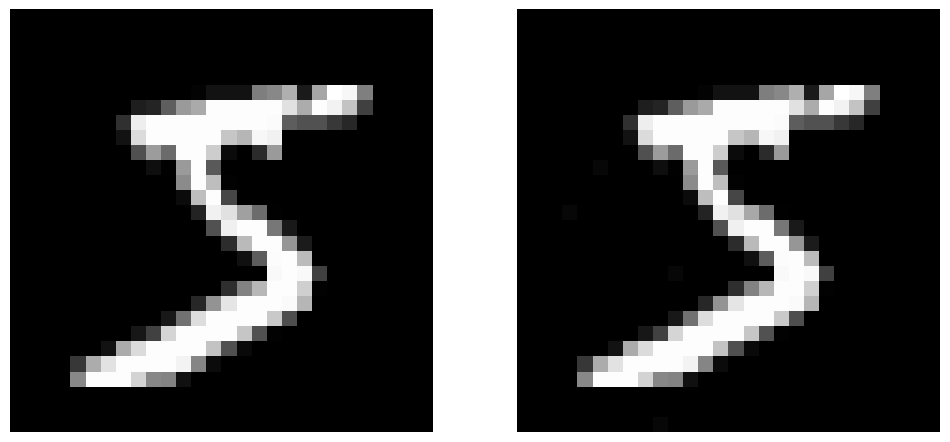

In [125]:
plot_imgs(two)

In [136]:
(~(two[0] == two[1])).view(-1).sum()

tensor(5)

In [126]:
succeeded.jacobian_matrix_rank(two)

tensor(20)

In [228]:
def how_many_pixels(model, tensor, limit=1000, change_amount=0.01):
    rank = model.jacobian_matrix_rank(tensor)
    added = 0
    while model.jacobian_matrix_rank(tensor) == rank:
        tensor[1] = with_changed_pixel(tensor[1], change_amount=change_amount)
        added += 1
        if added > limit:
            print("TOO MANY, ABORTING")
            return False
    return added, model.jacobian_matrix_rank(tensor).item()

In [235]:
def dist_of_pixels_to_change(model, ds, N=1000, change_amount=0.01):
    n_pixels = []
    final_ranks = []
    failures = 0
    for i in tqdm(range(N)):
        j = t.randint(0, len(ds), (1,)).item()
        two = tensor_of_dataset(ds, [j, j]).clone()
        result = how_many_pixels(model, two, change_amount=change_amount)
        if result:
            pixels, final_rank = result
            n_pixels.append(pixels)
            final_ranks.append(final_rank)
        else:
            failures += 1
    print(f"Failures: {failures}")
    return n_pixels, final_ranks

In [184]:
dist_of_pixels, dist_of_ranks = dist_of_pixels_to_change(succeeded, ds, N=500)

Failures: 0


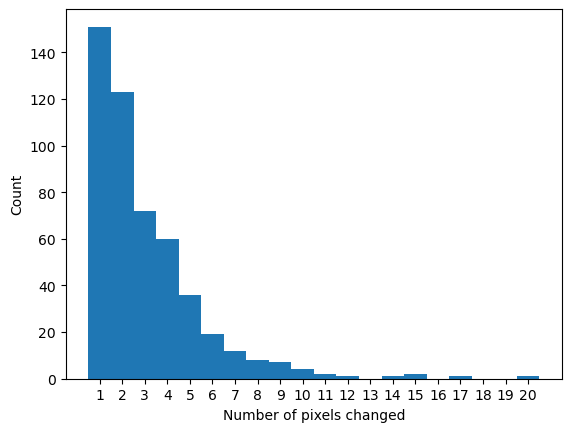

In [229]:
integer_histogram(dist_of_pixels, xlabel="Number of pixels changed")

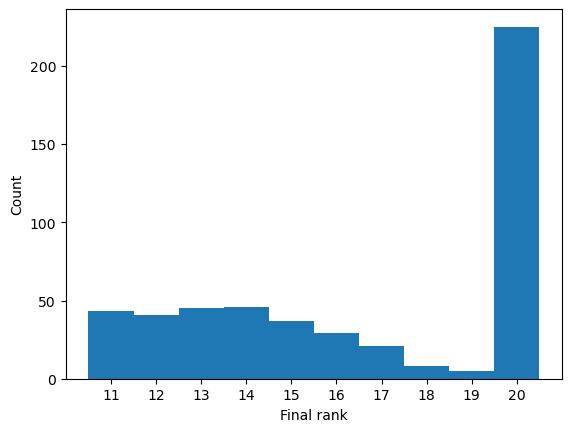

In [230]:
integer_histogram(dist_of_ranks, xlabel="Final rank")

In [231]:
def plot_dist_of_pixels_and_ranks(dist_of_pixels, dist_of_ranks):
    if not t.is_tensor(dist_of_pixels):
        dist_of_pixels = t.tensor(dist_of_pixels)
    if not t.is_tensor(dist_of_ranks):
        dist_of_ranks = t.tensor(dist_of_ranks)
    dist_2d = t.zeros(dist_of_pixels.max() + 1, dist_of_ranks.max() + 1)
    for i in range(len(dist_of_pixels)):
        dist_2d[dist_of_pixels[i], dist_of_ranks[i]] += 1
    plt.imshow(dist_2d)
    plt.xlabel("Final rank")
    plt.ylabel("Number of pixels changed")

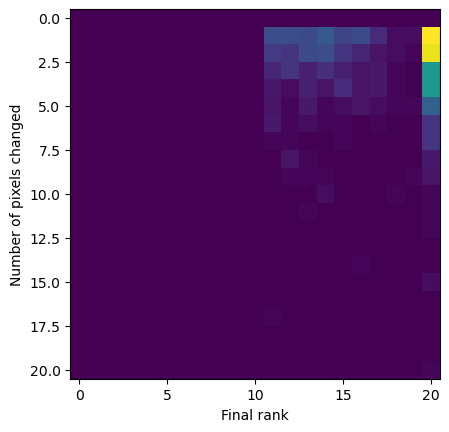

In [232]:
plot_dist_of_pixels_and_ranks(dist_of_pixels, dist_of_ranks)

In [236]:
change_amounts = [0.01, 0.1, 1]
dists_of_ranks = []
dists_of_pixels = []
for change_amount in change_amounts:
    print(f"Change amount: {change_amount}")
    dist_of_pixels, dist_of_ranks = dist_of_pixels_to_change(succeeded, ds, N=500, change_amount=change_amount)
    dists_of_ranks.append(dist_of_ranks)
    dists_of_pixels.append(dist_of_pixels)

Change amount: 0.01


  0%|          | 0/500 [00:00<?, ?it/s]

Failures: 0
Change amount: 0.1


  0%|          | 0/500 [00:00<?, ?it/s]

Failures: 0
Change amount: 1


  0%|          | 0/500 [00:00<?, ?it/s]

Failures: 0


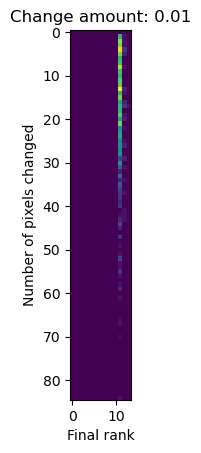

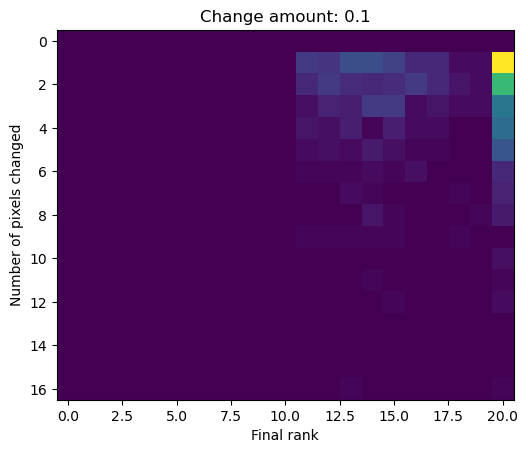

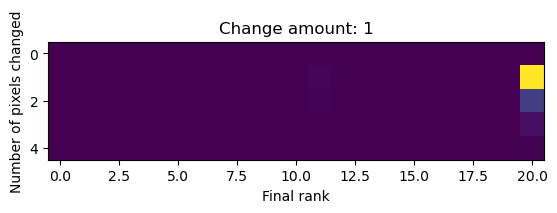

In [237]:
for i, change_amount in enumerate(change_amounts):
    plt.figure()
    plt.title(f"Change amount: {change_amount}")
    plot_dist_of_pixels_and_ranks(dists_of_pixels[i], dists_of_ranks[i])